# AI in Medicine I - Practical 2: Brain Tissue Segmentation

Segmentation of different tissues from MRI scans of the brain is an important step for further downstream applications such as disease prediction, classification or brain age estimation.

The goal of the coursework is to implement classical and deep learning approaches for segmentation of different tissue types in MRI scans of the brain, i.e., background, cerebrospinal fluid (CSF), white matter (WM), and gray matter (GM). We provide data from a total of 652 healthy subjects, that is split into different development sets and a hold-out test set on which you will evaluate your final segmentation accuracy.
Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are three dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

**Make sure to select the correct runtime when working in Google Colab (GPU)**

### Read the text descriptions and code cells carefully and look out for the cells marked with 'TASK', 'ADD YOUR CODE HERE', and 'QUESTION'.

In [4]:
# Only run this cell when in Google Colab
! git init
! git remote add origin https://github.com/compai-lab/aim-practical-2-brain-segmentation.git
! git fetch
! git checkout -t origin/main

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 88 (delta 52), reused 6 (delta 0), pack-reused 0
Unpacking objects: 100% (88/88), done.
From https://github.com/compai-lab/aim-practical-2-brain-segmentation
 * [new branch]      main       -> origin/main
Branch 'main' set up to track remote branch 'main' from 'origin'.
Switched to a new branch 'main'


## Downloading the Data

In [1]:
! wget -q --show-progress https://www.dropbox.com/s/w9njau9t6rrheel/brainage-data.zip
! unzip -qq -o brainage-data.zip
! wget -q --show-progress https://www.dropbox.com/s/f5mt8p9pkszff3x/brainage-testdata.zip
! unzip -qq -o brainage-testdata.zip

brainage-data.zip   100%[===================>] 446.94M  25.3MB/s    in 17s     
brainage-testdata.z 100%[===================>]   1.49K  --.-KB/s    in 0s      


In [2]:
!unzip brainage-data.zip

Archive:  brainage-data.zip
replace data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110037_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110045_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110056_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110062_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110069_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110087_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110098_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110101_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110126_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110174_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110182_T1w_unbiased.nii.gz  
  inflating: data/brain_age/

## Imports

In [5]:
from argparse import Namespace

import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import Tensor
from tqdm import tqdm
import os
import glob

from data_utils import load_nii, load_segmentations
from plot_utils import plot_segmentations
from utils import seed_everything, TensorboardLogger
%load_ext tensorboard
%load_ext autoreload
%autoreload 2

## Getting started and familiarise ourselves with the data

We provide the data of 652 subjects from which we use 522 for training, 65 for validation, and the rest of 65 for testing your final model.

## Imaging data
Let's check out the imaging data that is available for each subject.

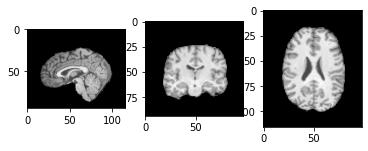

In [6]:
file = './data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz'

image = nib.load(file).get_fdata()

f, axarr = plt.subplots(1, 3)
H, W, D = image.shape
axarr[0].imshow(np.flip(image[H // 2, :, :].T, axis=0), cmap='gray')
axarr[1].imshow(np.flip(image[:, W // 2, :].T, axis=0), cmap='gray')
axarr[2].imshow(image[:, :, D // 2].T, cmap='gray')
plt.show()

## Data loading and visualization

Let's first load all the data and make a tranin/val/test split

In [7]:
paths = sorted(glob.glob('data/brain_age/segs_refs/*'))
filenames, segmentations = load_segmentations(paths)

100%|██████████| 652/652 [00:04<00:00, 130.97it/s]


In [8]:
np.random.seed(10282022)

all_keys = np.asarray(range(len(filenames)))
ratio_test = int(0.1 * len(all_keys))  # 10% val; 10% test
val_keys = np.random.choice(all_keys, 2 * ratio_test, replace=False)
test_keys = np.random.choice(val_keys, ratio_test, replace=False)

train_files, val_files, test_files = [], [], []
segmentations_train, segmentations_val, segmentations_test =  [],  [], [] 
for scan_id in tqdm(all_keys):
  scan = f'data/brain_age/images/sub-{filenames[scan_id]}_T1w_unbiased.nii.gz'
  seg = segmentations[scan_id]
  if scan_id in test_keys:
      test_files.append(scan)
      segmentations_test.append(seg)
  elif scan_id in val_keys:
      val_files.append(scan)
      segmentations_val.append(seg)
  else:
      train_files.append(scan)
      segmentations_train.append(seg)
print(f'{len(train_files)} train files')
print(f'{len(val_files)} val files')
print(f'{len(test_files)} test files')

100%|██████████| 652/652 [00:00<00:00, 93429.66it/s]

522 train files
65 val files
65 test files


Let's visualize one validations sample 

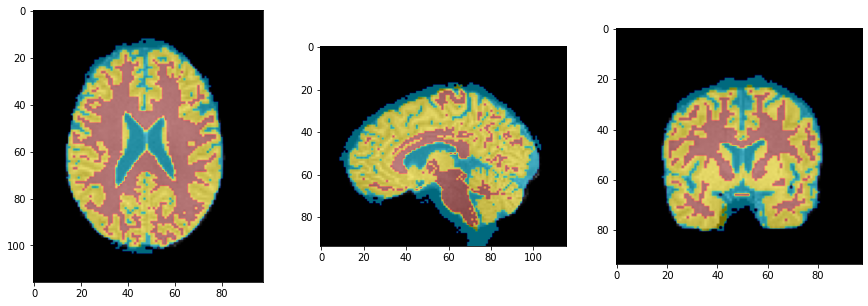

In [9]:
im = load_nii(val_files[0])
plot_segmentations(im, segmentations_val[0], i=47)

# Task 1: Evaluation: TASK

We first have to define how good our predicted segmentations are. Implement the evaluation function below. 

In [12]:
# The Dice similarity coefficient is widely used for evaluating image segmentation alogrithms and measures the intersection over union of predicted segmentations to ground truth
# Implement a method that computes the patient-wise Dice score (mean and std) for the test dataset
# --------------------------- ADD YOUR CODE HERE ------------------------------
def Dice(predictions, gt, k):
  ### gt is a list with segmented data with shape (n, 98, 116, 94), with n as the num of data we have (number of patients)
  ### assumed predictions output should be the same shape as gt
  ### get Dice mean / std of patients regarding segmentation = k 
  
  dice = np.zeros(len(predictions))
  for i in range (len(predictions)):
    dice[i] = 2*(np.sum(predictions[i][gt[i] == k]))/(np.sum(predictions[i])+np.sum(gt[i]))
  mean, std = np.mean(dice), np.std(dice)  
  return mean, std
# ----------------------------------- END -------------------------------------

# Task 2: Unsupervised segmentation 

The first approach aims to segment the brain tissues, including grey matter (GM), white matter (WM), cerebrospinal fluid (CSF), and background using unsupervised classical machine learning techniques.

Different unsupervised techniques to leverage the different intensity profile of the tissues should be explored. 

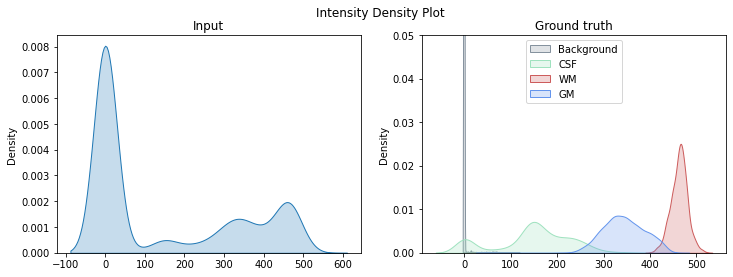

In [10]:
slice_id = 0
im_ = load_nii(val_files[slice_id])[:,:,47].flatten()
seg_ = segmentations_val[slice_id][:,:,47].flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
fig.suptitle('Intensity Density Plot')

sns.kdeplot(im_, ax=axes[0], fill=True)
axes[0].set_title('Input')

sns.kdeplot(im_[np.argwhere(seg_ == 0)][:, 0], ax=axes[1], fill=True, color='#85929E', label='Background', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 1)][:, 0], ax=axes[1], fill=True, color='#9FE2BF', label='CSF', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 3)][:, 0], ax=axes[1], fill=True, color='#CD5C5C', label='WM', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 2)][:, 0], ax=axes[1], fill=True, color='#6495ED', label='GM', legend=True)
axes[1].set_ylim(0, 0.05)
axes[1].set_title('Ground truth')
plt.legend(loc=9, labels=['Background', 'CSF', 'WM', 'GM'])

## Unsupervised Learning: TASK

Here, you should experiment with different *classical* unsupervised machine learning methods, e.g., clustering, density estimation, etc... (at least two different methods). Hint: sklearn has implementations of unsupervised methods

HINT: You can predict the different classes of intensities even without any training!

HINT: You can evaluate every volume slice-by-slice if the whole volume does not fit in the memory.

### QUESTION Q1: What is the most intuitve segmentation approach? (based on the intensity density plot of the input)
Hint: What distibution best describes the intensity density plot above? 

The distribution has the shape of Gaussians (sum 
of Gaussians with different mean and variance). Therefore the most intuitive segmentation approach is GMM (Gaussian Mixture Model).

### QUESTION Q2: Evaluate the Dice scores (separately for every tissue type) for the whole test set using method 1. What results do you get? 

In [13]:
# Unsupervised method 1 
# --------------------------- ADD YOUR CODE HERE ------------------------------
from sklearn.cluster import KMeans
pred_seg_1 = []
shape = load_nii(test_files[0]).shape
for i in range(len(test_files)):
  kmeans = KMeans(n_clusters = 4).fit_predict(load_nii(test_files[i]).flatten().reshape(-1,1))
  kmeans = kmeans.reshape(shape)
  pred_seg_1.append(kmeans)
  
mean00, std00 = Dice(pred_seg_1, segmentations_test, 0)
mean11, std11 = Dice(pred_seg_1, segmentations_test, 1)
mean22, std22 = Dice(pred_seg_1, segmentations_test, 2)
mean33, std33 = Dice(pred_seg_1, segmentations_test, 3)

print("result of KMeans for tissue type 0 -  mean : ",  mean00, " std: ", std00)
print("result of KMeans for tissue type 1 -  mean : ",  mean11, " std: ", std11)
print("result of KMeans for tissue type 2 -  mean : ",  mean22, " std: ", std22)
print("result of KMeans for tissue type 3 -  mean : ",  mean33, " std: ", std33)
# ----------------------------------- END -------------------------------------

result of KMeans for tissue type 0 -  mean :  0.24523140844777722  std:  0.465407556618406
result of KMeans for tissue type 1 -  mean :  0.20548425288559563  std:  0.06989457769749824
result of KMeans for tissue type 2 -  mean :  0.3470622611619801  std:  0.1475951940223776
result of KMeans for tissue type 3 -  mean :  0.23936391663861742  std:  0.14090991523330743


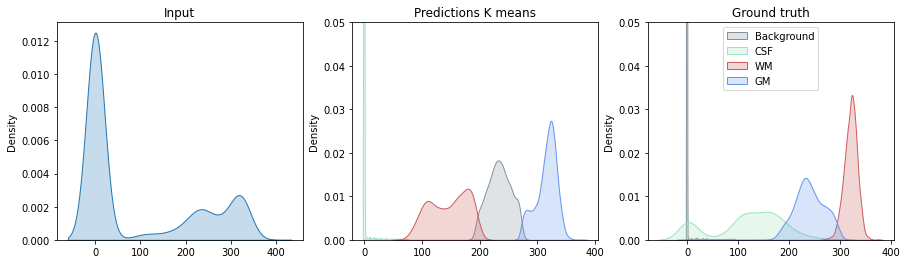

In [14]:
# Plot the obtained results for volume 0 and axial slice 47 of the validations set (density estimations)
# --------------------------- ADD YOUR CODE HERE ------------------------------

slice_id = 0
img = load_nii(test_files[slice_id])[:,:,47].flatten()
pred1 = pred_seg_1[slice_id][:,:,47].flatten()
seg_ = segmentations_test[slice_id][:,:,47].flatten()

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

sns.kdeplot(img, ax=axes[0], fill=True)
axes[0].set_title('Input')

sns.kdeplot(img[np.argwhere(pred1 == 0)][:, 0], ax=axes[1], fill=True, color='#85929E', label='Background', legend=True)
sns.kdeplot(img[np.argwhere(pred1 == 1)][:, 0], ax=axes[1], fill=True, color='#9FE2BF', label='CSF', legend=True)
sns.kdeplot(img[np.argwhere(pred1 == 3)][:, 0], ax=axes[1], fill=True, color='#CD5C5C', label='WM', legend=True)
sns.kdeplot(img[np.argwhere(pred1 == 2)][:, 0], ax=axes[1], fill=True, color='#6495ED', label='GM', legend=True)
axes[1].set_ylim(0, 0.05)
axes[1].set_title('Predictions K means')
#plt.legend(loc=9, labels=['Background', 'CSF', 'WM', 'GM'])




sns.kdeplot(img[np.argwhere(seg_ == 0)][:, 0], ax=axes[2], fill=True, color='#85929E', label='Background', legend=True)
sns.kdeplot(img[np.argwhere(seg_ == 1)][:, 0], ax=axes[2], fill=True, color='#9FE2BF', label='CSF', legend=True)
sns.kdeplot(img[np.argwhere(seg_ == 3)][:, 0], ax=axes[2], fill=True, color='#CD5C5C', label='WM', legend=True)
sns.kdeplot(img[np.argwhere(seg_ == 2)][:, 0], ax=axes[2], fill=True, color='#6495ED', label='GM', legend=True)
axes[2].set_ylim(0, 0.05)
axes[2].set_title('Ground truth')
plt.legend(loc=9, labels=['Background', 'CSF', 'WM', 'GM'])
# ----------------------------------- END -------------------------------------

### QUESTION Q3: Evaluate the Dice scores (separately for every tissue type) for the whole test set using method 2. What results do you get? 

In [16]:
# Unsupervised method 2 
# --------------------------- ADD YOUR CODE HERE ------------------------------
from sklearn.mixture import GaussianMixture

pred_seg_2 = []
shape = load_nii(test_files[0]).shape
for i in range(len(test_files)):
  gm = GaussianMixture(n_components = 4).fit_predict(load_nii(test_files[i]).flatten().reshape(-1,1))
  gm = gm.reshape(shape)
  pred_seg_2.append(gm)

mean0, std0 = Dice(pred_seg_2, segmentations_test, 0)
mean1, std1 = Dice(pred_seg_2, segmentations_test, 1)
mean2, std2 = Dice(pred_seg_2, segmentations_test, 2)
mean3, std3 = Dice(pred_seg_2, segmentations_test, 3)


print("result of GMM for tissue type 0 -  mean : ",  mean0, " std: ", std0)
print("result of GMM for tissue type 1 -  mean : ",  mean1, " std: ", std1)
print("result of GMM for tissue type 2 -  mean : ",  mean2, " std: ", std2)
print("result of GMM for tissue type 3 -  mean : ",  mean3, " std: ", std3)

# ----------------------------------- END -------------------------------------

result of GMM for tissue type 0 -  mean :  0.1943419246143156  std:  0.3967143477608948
result of GMM for tissue type 1 -  mean :  0.22274159488812775  std:  0.07542600333335903
result of GMM for tissue type 2 -  mean :  0.3597179826416114  std:  0.15143547021114812
result of GMM for tissue type 3 -  mean :  0.2527869369414181  std:  0.142564446064107


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


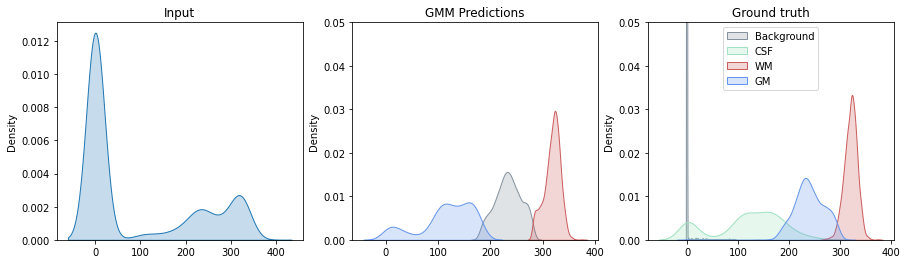

In [17]:

slice_id = 0
im_ = load_nii(test_files[slice_id])[:,:,47].flatten()
pred2 = pred_seg_2[slice_id][:,:,47].flatten()
seg_ = segmentations_test[slice_id][:,:,47].flatten()

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

sns.kdeplot(im_, ax=axes[0], fill=True)
axes[0].set_title('Input')

sns.kdeplot(im_[np.argwhere(pred2 == 0)][:, 0], ax=axes[1], fill=True, color='#85929E', label='Background', legend=True)
sns.kdeplot(im_[np.argwhere(pred2 == 1)][:, 0], ax=axes[1], fill=True, color='#9FE2BF', label='CSF', legend=True)
sns.kdeplot(im_[np.argwhere(pred2 == 3)][:, 0], ax=axes[1], fill=True, color='#CD5C5C', label='WM', legend=True)
sns.kdeplot(im_[np.argwhere(pred2 == 2)][:, 0], ax=axes[1], fill=True, color='#6495ED', label='GM', legend=True)
axes[1].set_ylim(0, 0.05)
axes[1].set_title('GMM Predictions')
#plt.legend(loc=9, labels=['Background', 'CSF', 'WM', 'GM'])




sns.kdeplot(im_[np.argwhere(seg_ == 0)][:, 0], ax=axes[2], fill=True, color='#85929E', label='Background', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 1)][:, 0], ax=axes[2], fill=True, color='#9FE2BF', label='CSF', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 3)][:, 0], ax=axes[2], fill=True, color='#CD5C5C', label='WM', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 2)][:, 0], ax=axes[2], fill=True, color='#6495ED', label='GM', legend=True)
axes[2].set_ylim(0, 0.05)
axes[2].set_title('Ground truth')
plt.legend(loc=9, labels=['Background', 'CSF', 'WM', 'GM'])

# ----------------------------------- END -------------------------------------

### QUESTION Q4: Which approach worked better? Why? 

The mean of the Dice score was better with GMM, however standard deviation was higher in GMM than K-means. Moreover, both results were quite similar. Looking at the graph, one can see GMM predicted better than K-means, although GMM failed to predict background in this case. One can say that since the intensity distribution follows the sum of Gaussian, GMM predicts better results.

# Task 3: Deep supervised segmentation

Deep Learning (DL) methods achieve state-of-the-art results in many (medical) image analyzis applications, including segmentation. Here, you will implement and train a DL method to segment CSF, WM, GM, and background in brain MRI.

First, let's have a look at the individual channels of the segmentations. 

(98, 116, 94) (98, 116, 94)


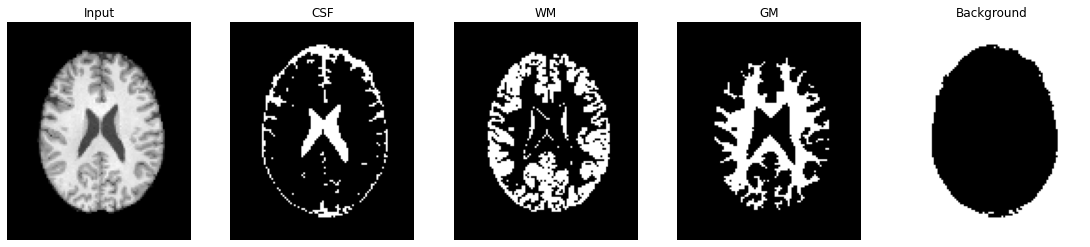

In [18]:
import matplotlib.pyplot as plt
import copy
im = load_nii(val_files[0])
print(im.shape, segmentations_val[0].shape)
csf, wm, gm, background = np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape)
csf[segmentations_val[0]==1] = 1
wm[segmentations_val[0]==2] = 1
gm[segmentations_val[0]==3] = 1
background[segmentations_val[0]==0]=1
elements = [im, csf, wm, gm, background] 
titles = ['Input', 'CSF', 'WM', 'GM', 'Background']
diffp, axarr = plt.subplots(1, len(elements), gridspec_kw={'wspace': 0, 'hspace': 0})
diffp.set_size_inches(len(elements) * 4, 4)
for idx_arr in range(len(axarr)):
    axarr[idx_arr].axis('off')
    el = np.squeeze(elements[idx_arr][:,:,47])
    axarr[idx_arr].imshow(el.T, cmap='gray')
    axarr[idx_arr].set_title(titles[idx_arr])

## DL-based segmentation: TASK

Define and train a neural network for segmentation below (use the train, val, and test splits defined above)

HINT: You can use pre-defined models, e.g., from torchvision, but train them from scratch (no pre-training)

In [19]:
from typing import List, Tuple

import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
 
class BrainImageDataset(Dataset):
    def __init__(self, mode: str, img_size: int, ):
        assert mode in ['train', 'val', 'test']
        print(f'Loading {mode} data...')
        self.images = []
        self.seg = []
        if mode == 'train':
            for i in range(len(train_files)):
              self.images.append((load_nii(train_files[i])))
              self.seg.append((segmentations_train[i]))
        elif mode == 'val':
            for i in range(len(val_files)):
              self.images.append((load_nii(val_files[i])))
              self.seg.append((segmentations_val[i]))
        if mode == 'test':
            for i in range(len(test_files)):
              self.images.append((load_nii(test_files[i])))
              self.seg.append((segmentations_test[i]))
        self.images = torch.Tensor(np.array(self.images))
        self.seg  = torch.Tensor(np.array(self.seg))
    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        """Get a brain MR-image and it's corresponding age

        :param idx: Sample index of the dataset
        :return img: Loaded brain MRI. Shape (H, W, D)
        """
        img = self.images[idx]
        seg = self.seg[idx]
        return img, seg

def get_image_dataloaders(
    img_size: int,
    batch_size: int,
    num_workers: int = 0
):
    print('Loading data. This might take a while...')
    train_ds = BrainImageDataset('train', img_size)
    val_ds = BrainImageDataset('val', img_size)
    test_ds = BrainImageDataset('test', img_size)

    train_dl = DataLoader(train_ds, batch_size, shuffle=False, num_workers=num_workers)
    val_dl = DataLoader(val_ds, batch_size, shuffle=False, num_workers=num_workers)
    test_dl = DataLoader(test_ds, batch_size, shuffle=False, num_workers=num_workers)

    return {'train': train_dl, 'val': val_dl, 'test': test_dl}


In [20]:
config = Namespace()
config.img_size = 96
config.batch_size = 1
config.num_workers = 2

config.log_dir = './logs'
config.val_freq = 30
config.log_freq = 30

config.seed = 0
config.device = 'cuda'

seed_everything(config.seed)

In [21]:


dataloaders = get_image_dataloaders(
    img_size=config.img_size,
    batch_size=config.batch_size,
    num_workers=config.num_workers
)

Loading data. This might take a while...
Loading train data...
Loading val data...
Loading test data...


In [22]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 31.1 MB/s 


In [23]:
# Define and train a neural network for segmentation
# --------------------------- ADD YOUR CODE HERE ------------------------------
import torchvision.models as models
import torch.nn as nn
import torchmetrics
from torchmetrics.functional import dice_score

# Number of classes in the dataset
class AvgMeter:
    def __init__(self):
        self.value = 0.
        self.n = 0

    def add(self, value):
        self.value += value
        self.n += 1

    def compute(self):
        return self.value / self.n


def train(config, model, optimizer, train_loader, val_loader, writer):
    avg_loss = AvgMeter()
    model.train()
    step = 0
    pbar = tqdm(total=config.val_freq,
                desc=f'Training')

    while True:
        for x, y in train_loader:
            x = x.to(config.device)
            y = y.to(config.device)
            pbar.update(1)

            # Training step
            optimizer.zero_grad()
            loss = model.train_step(imgs= x, labels= y)
            loss.backward()
            optimizer.step()

            avg_loss.add(loss.detach().item())

            # Increment step
            step += 1

            if step % config.log_freq == 0 and not step % config.val_freq == 0:  
                train_loss = avg_loss.compute()
                writer.log({'train/loss': train_loss}, step=step)

            # Validate and log at validation frequency
            if step % config.val_freq == 0:
                # Reset avg_loss
                train_loss = avg_loss.compute()

                # Get validation results
                val_results = validate(
                    model,
                    val_loader,
                    config,
                )
                # Print current performance
                print(f"Finished step {step} of {config.num_steps}. "
                      f"Train loss: {train_loss} - "
                      f"val loss: {val_results['val/loss']:.4f} - ")

                # Write to tensorboard
               # writer.log(val_results, step=step)

                # Reset progress bar
                pbar = tqdm(total=config.val_freq, desc='Training')

            if step >= config.num_steps:
                print(f'\nFinished training after {step} steps\n')
                return model, step


def validate(model, val_loader, config, show_plot=False):
    model.eval()
    avg_val_loss = AvgMeter()
    preds = []
    targets = []
    loss = nn.CrossEntropyLoss()
    for x, y in val_loader:
        x = x.to(config.device)
        y = y.to(config.device)

        with torch.no_grad():
            loss, pred = model.train_step(x, y, return_prediction=True)
        avg_val_loss.add(loss.item())
        preds.append(pred.cpu())
        targets.append(y.cpu())

    preds = torch.cat(preds)
    targets = torch.cat(targets)
    model.train()
    return {
        'val/loss': avg_val_loss.compute(),
        'val/MAE_plot': f
    }


pred_seg_3 = None 
# ----------------------------------- END -------------------------------------

In [24]:
config.lr = 0.001
config.betas = [0.9, 0.999]
config.num_steps = 600

In [25]:
! pip install torchgeometry

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 1.2 MB/s 


In [26]:
import torch
torch.cuda.empty_cache()

In [27]:
from models import BrainAgeCNN as Model

model = Model()
model = model.to(config.device)

In [28]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas
)
# Init tensorboard
writer = TensorboardLogger(config.log_dir, config)
# Train
model, step = train(
    config=config,
    model=model,
    optimizer=optimizer,
    train_loader=dataloaders['train'],
    val_loader=dataloaders['val'],
    writer = writer
)

Training: 100%|██████████| 30/30 [01:30<00:00,  2.91s/it]

Finished step 30 of 600. Train loss: 0.7285262783368428 - val loss: 0.8622 - 



Training: 100%|██████████| 30/30 [02:30<00:00,  5.02s/it]

Training: 100%|██████████| 30/30 [01:28<00:00,  3.09s/it]

Finished step 60 of 600. Train loss: 0.5304985644916693 - val loss: 0.3099 - 


Training: 100%|██████████| 30/30 [01:29<00:00,  3.08s/it]

Finished step 90 of 600. Train loss: 0.4166920539405611 - val loss: 0.2351 - 



Training: 100%|██████████| 30/30 [02:31<00:00,  5.05s/it]

Training: 100%|██████████| 30/30 [01:29<00:00,  3.08s/it]

Finished step 120 of 600. Train loss: 0.34911737193663916 - val loss: 0.2049 - 


Training: 100%|██████████| 30/30 [01:29<00:00,  3.08s/it]

Finished step 150 of 600. Train loss: 0.30422876487175626 - val loss: 0.2069 - 



Training: 100%|██████████| 30/30 [02:31<00:00,  5.06s/it]

Training: 100%|██████████| 30/30 [01:29<00:00,  3.08s/it]

Finished step 180 of 600. Train loss: 0.2720997892734077 - val loss: 0.3091 - 


Training: 100%|██████████| 30/30 [01:29<00:00,  3.08s/it]

Finished step 210 of 600. Train loss: 0.24740194706689744 - val loss: 0.1682 - 



Training: 100%|██████████| 30/30 [02:31<00:00,  5.07s/it]

Training: 100%|██████████| 30/30 [01:29<00:00,  3.07s/it]

Finished step 240 of 600. Train loss: 0.22764991850902636 - val loss: 0.1704 - 


Training: 100%|██████████| 30/30 [01:29<00:00,  3.08s/it]

Finished step 270 of 600. Train loss: 0.21249557145767742 - val loss: 0.1664 - 



Training: 100%|██████████| 30/30 [02:31<00:00,  5.06s/it]

Training: 100%|██████████| 30/30 [01:29<00:00,  3.09s/it]

Finished step 300 of 600. Train loss: 0.2000435249010722 - val loss: 0.1730 - 


Training: 100%|██████████| 30/30 [01:29<00:00,  3.09s/it]

Finished step 330 of 600. Train loss: 0.18965056667273694 - val loss: 0.1983 - 



Training: 100%|██████████| 30/30 [02:31<00:00,  5.06s/it]

Training: 100%|██████████| 30/30 [01:29<00:00,  3.09s/it]

Finished step 360 of 600. Train loss: 0.18024236071440908 - val loss: 0.1639 - 


Training: 100%|██████████| 30/30 [01:29<00:00,  3.08s/it]

Finished step 390 of 600. Train loss: 0.17225099025437465 - val loss: 0.1777 - 



Training: 100%|██████████| 30/30 [02:31<00:00,  5.06s/it]

Training: 100%|██████████| 30/30 [01:29<00:00,  3.09s/it]

Finished step 420 of 600. Train loss: 0.16544181238859892 - val loss: 0.3347 - 


Training: 100%|██████████| 30/30 [01:29<00:00,  3.08s/it]

Finished step 450 of 600. Train loss: 0.16035216542581718 - val loss: 0.1488 - 



Training: 100%|██████████| 30/30 [02:32<00:00,  5.07s/it]

Training: 100%|██████████| 30/30 [01:29<00:00,  3.08s/it]

Finished step 480 of 600. Train loss: 0.1560600783287858 - val loss: 0.2690 - 


Training: 100%|██████████| 30/30 [01:29<00:00,  3.09s/it]

Finished step 510 of 600. Train loss: 0.15161659849771097 - val loss: 0.2302 - 



Training: 100%|██████████| 30/30 [02:32<00:00,  5.07s/it]

Training: 100%|██████████| 30/30 [01:29<00:00,  3.09s/it]

Finished step 540 of 600. Train loss: 0.14768602225101657 - val loss: 0.2294 - 


Training: 100%|██████████| 30/30 [01:29<00:00,  3.09s/it]

Finished step 570 of 600. Train loss: 0.14354408534995297 - val loss: 0.1656 - 



Training: 100%|██████████| 30/30 [02:32<00:00,  5.08s/it]

Training: 100%|██████████| 30/30 [01:29<00:00,  3.09s/it]

Finished step 600 of 600. Train loss: 0.13927407670145234 - val loss: 0.1377 - 


Training: 100%|██████████| 30/30 [02:32<00:00,  5.08s/it]


Finished training after 600 steps




Training:   0%|          | 0/30 [00:00<?, ?it/s]


In [67]:
im = load_nii(test_files[0])
model.eval()
model = model.to("cpu")
im = torch.Tensor(im)
pred = model.forward((im.view(1, 1, 98, 116, 94)))
copy = pred.argmax(dim = 1)
print(pred.shape, copy.shape)

torch.Size([1, 4, 98, 116, 94]) torch.Size([1, 98, 116, 94])


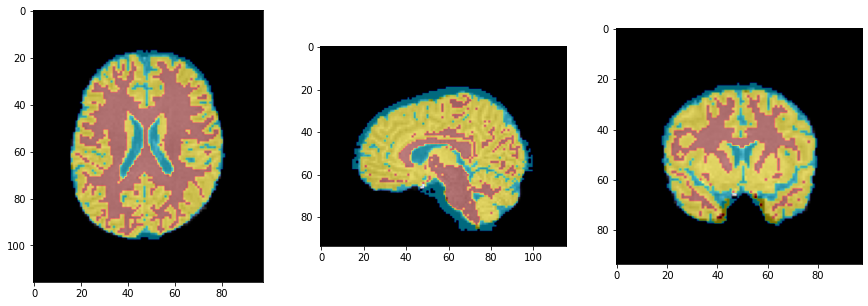

In [30]:
plot_segmentations(im, segmentations_test[0], i=47) ## gt plot

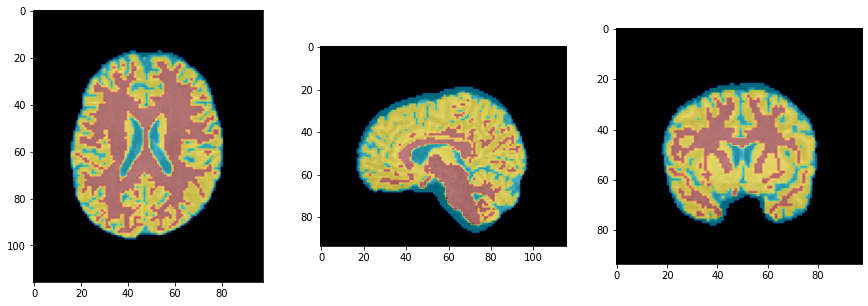

In [31]:
plot_segmentations(im, copy.view(98, 116, 94), i=47)  ## predicted plot

### QUESTION Q5: Evaluate the Dice scores (separately for every tissue type) for the whole test set.  What results do you get? 

In [68]:
prediction = []
for i in range(len(test_files)):
  im = load_nii(test_files[i])
  im = torch.Tensor(im)
  pred = model.forward((im.view(1, 1, 98, 116, 94)))
  pred = pred.argmax(dim = 1)
  pred = pred.view(98, 116, 94)
  prediction.append(pred)

In [92]:
def Dice_torch(predictions, gt, k):
  ### gt is a list with segmented data with shape (n, 98, 116, 94), with n as the num of data we have (number of patients)
  ### assumed predictions output should be the same shape as gt
  ### get Dice mean / std of patients regarding segmentation = k 
  
  dice = np.zeros(len(predictions))
  for i in range (len(predictions)):
    dice[i] = 2*(torch.sum(prediction[i][segmentations_test[i] == k]))/(torch.sum(prediction[i])+torch.sum(torch.from_numpy(segmentations_test[i])))
  mean, std = np.mean(dice), np.std(dice)  
  return mean, std

In [95]:
mean0, std0 = Dice_torch(prediction, segmentations_test, 0)  
mean1, std1 = Dice_torch(prediction, segmentations_test, 1)
mean2, std2 = Dice_torch(prediction, segmentations_test, 2)
mean3, std3 = Dice_torch(prediction, segmentations_test, 3)

print("background mean : ", mean0, " std : ", std0)
print("csf mean : ", mean1, " std : ", std1)
print("wm mean : ", mean2, " std : ", std2)
print("gm mean : ", mean3, " std : ", std3)

background mean :  0.009303262253076984  std :  0.004549897668383332
csf mean :  0.13272098944737362  std :  0.030192506173327614
wm mean :  0.44799680297191324  std :  0.05819648110515802
gm mean :  0.40238101115593544  std :  0.02657678468226486


In [96]:
im = load_nii(test_files[0])
prediction = model.forward((torch.Tensor(im).view(1,1, 98, 116, 94)))
prediction = prediction.argmax(dim= 1)
prediction = prediction.view(98, 116, 94)

In [47]:
KMM_1 = pred_seg_1[0]
GMM_1 = pred_seg_2[0]

In [121]:
def plot_segresult(img, pred, title, isGMM = False, isKM = False):
  csf, wm, gm, background = np.zeros(img.shape), np.zeros(img.shape), np.zeros(img.shape), np.zeros(img.shape)
  if isGMM:
    csf[GMM_1==2] = 1
    wm[GMM_1==0] = 1
    gm[GMM_1==3] = 1
    background[GMM_1==1]=1
  elif isKM:
    csf[KMM_1==3] = 1
    wm[KMM_1==0] = 1
    gm[KMM_1==2] = 1
    background[KMM_1==1]=1
  else:
    csf[pred==1] = 1
    wm[pred==2] = 1
    gm[pred==3] = 1
    background[pred==0]=1
  elements = [img, csf, wm, gm, background] 
  titles = ['Input', 'CSF', 'WM', 'GM', 'Background']
  diffp, axarr = plt.subplots(1, len(elements), gridspec_kw={'wspace': 0, 'hspace': 0})
  diffp.suptitle(title, fontsize=16)
  diffp.set_size_inches(len(elements) * 4, 4)
  for idx_arr in range(len(axarr)):
      axarr[idx_arr].axis('off')
      el = np.squeeze(elements[idx_arr][:,:,47])
      axarr[idx_arr].imshow(el.T, cmap='gray')
      axarr[idx_arr].set_title(titles[idx_arr])

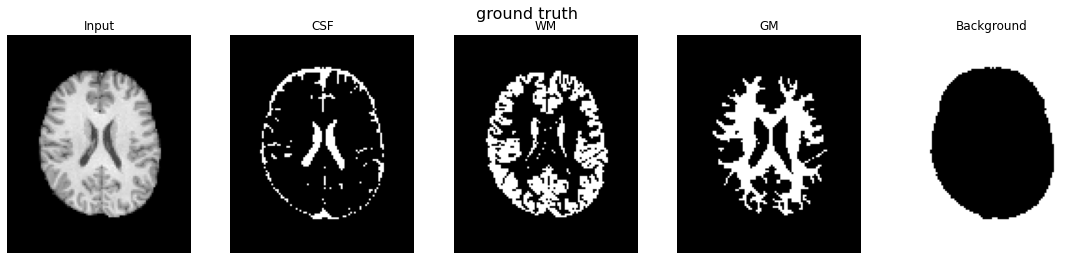

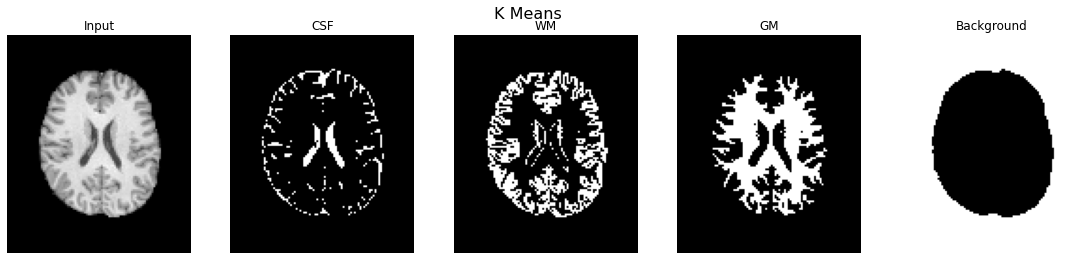

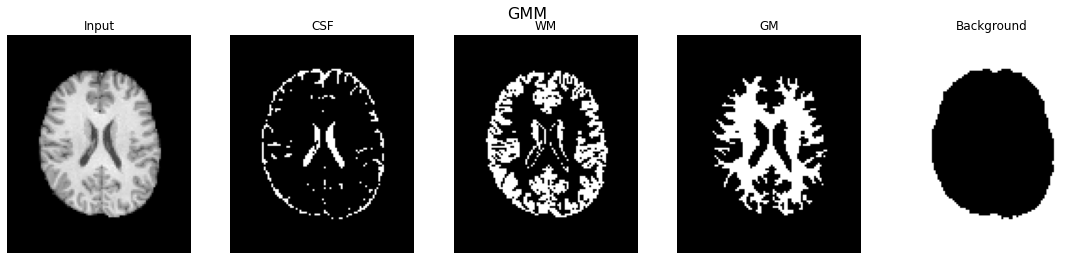

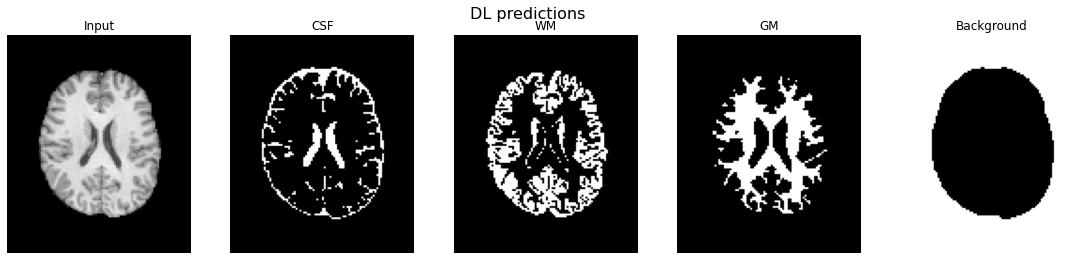

In [122]:
im = load_nii(test_files[0])
gt = segmentations_test[0]
KMM_1 = pred_seg_1[0]
GMM_1 = pred_seg_2[0]
plot_segresult(im, gt, "ground truth")
plot_segresult(im, KMM_1, "K Means",isKM = True )
plot_segresult(im, GMM_1, "GMM",isGMM=True)
plot_segresult(im, prediction, "DL predictions")

### QUESTION Q6: Which of the three aproaches above (classical and DL) obtains better results? Why? 

DL works better since it is supervised. Not all intensity profiles will follow a Gaussian mixture distribution. It might differ according to the dataset. Therefore the unsupervised result would give worse results than the supervised DL method. 

### QUESTION Q7: What extra-information in the volumes is used by the DL models compared to the unsupervised approaches in Task 2? Why is it helpful? 

DL models have Information about already segmented data (Ground truth) compared to the unsupervised approaches. 
These models can learn high-level features (organs, lesions or tissue types of the input) and low-level features (capture fine details and accurate edges of the input) to get a higher dice score and make a better segmentation. Also, boundaries of the different tissue types are unclear, vary among patients and are difficult to learn without a supervised method. Therefore, a deep learning strategy is the best option nowadays for medical image segmentation.
